# Demo of bboxconverter

This notebook demonstrates the use of the `bboxconverter` package.


## Converting between formats


In [1]:
import bboxconverter as bt

# Input file path
input_path1 = './examples/example1.csv'
input_path2 = './examples/example2.manifest'

# Output file path
output_path1 = './examples/output/test1.csv'
output_path2 = './examples/output/test2.json'

# Mapping between the input file and the bboxconverter format
bbox_map = dict(
    class_name='class',
    file_path='name',
    x_min='top_left_x',
    y_min='top_left_y',
    width='w',
    height='h',
    image_width='img_size_x',
    image_height='img_size_y',
)

# Read the input file
parser = bt.read_csv(input_path1, mapping=bbox_map)


# Export the file to the desired format
parser.export(output_path=output_path2, format='coco')
parser.to_csv(output_path=output_path1, type='tlwh')


# parser.export(output_path=output2, format='yolo')
# parser.export(output_path=output, format='voc')
# parser.to_csv(output_path=output, type='tlbr')
# parser.to_csv(output_path=output, type='cwh')

print(f"File saved to {output_path1} and {output_path2}")


File saved to ./examples/output/test1.csv and ./examples/output/test2.json


## Displaying bounding boxes

In this section we will display bounding boxes on images using pycocotools package.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
COCO categories: 
cat dog



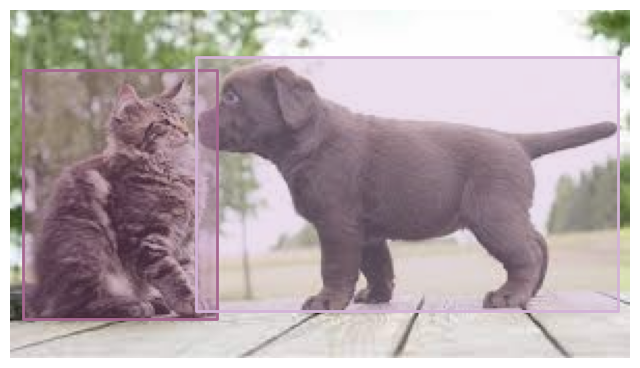

In [2]:
import pylab
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
from pycocotools.coco import COCO
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# Load COCO annotations
annFile = f'./examples/coco/result.json'
coco = COCO(annFile)
cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print(f'COCO categories: \n{" ".join(nms)}\n')

# Get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['cat', 'dog'])
imgIds = coco.getImgIds(catIds=catIds)
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]

# Load and display image
I = io.imread(
    f'examples/coco/images/{img["file_name"].split("/")[-1]}'
)
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)
